# Comparing Merton & Vasicek model implied yeild curves

In [1]:
import random_number as rn
from matplotlib import pyplot as plt
import short_rate_model as srm
import numpy as np
import scipy.stats as stats
import math

## Short Rate Dynamics

In [2]:
RNG1 = rn.RandomGen()
RNG2 = rn.RandomGen()

In [3]:
r0 = 0.05
vol = 0.02

# Merton
drift = 0.01

# Vasicek
speed = 0.1
long_term_mean = 0.02

merton = srm.Merton(r0, drift, vol, RNG1)
vasicek = srm.Vasicek(r0, speed, long_term_mean, vol, RNG2)

### Merton model:

The Merton short rate model is defined by the SDE:
$$
dr_t = \theta dt + \sigma dW_t
$$
Solving the SDE (simply integrating both sides), we get
$$
r_s = r_t + \theta (s-t) + \sigma (W_s - W_t)
$$

### Vasicek model:

The Vasicek short rate model is defined as:
\begin{align}
dr_t = k (\theta - r_t) \, dt + \sigma \, dW_t
\end{align}
We can rewrite the model as 
\begin{align}
dr_t + k r_t \, dt = \tilde{\theta} \, dt + \sigma \, dW_t
\end{align}
where $\tilde{\theta} := \kappa \theta$. In order to solve the SDE, we multiply both sides by $\exp(kt)$, resulting in
\begin{align}
d\big(\exp(kt) \, r_t \big) = \exp(kt) \, \tilde{\theta} \, dt + \tilde{\theta} \, \sigma \, dW_t.
\end{align}
Now the SDE can be integrated both sides from $t$ to $s$. Rearranging terms, we get:
\begin{align}
r_s &= \exp(-k(s-t)) \, r_t + \tilde{\theta} \int_t^s \exp(-k(s-u)) \, du + \int_t^s \exp(-k(s-u)) \, dW_u
\end{align}
The function $\int_t^s \exp(-k(s-u)) \, du$ is common when analysing the Vasicek model, thus we give it a name, $G(t,s \,|\, k)$:
\begin{align}
G(t,s \,|\, k) &\equiv \int_t^s \exp(-k(s-u)) \, du \\
                &= \frac{1 - \exp(-k(s-u))}{k}
\end{align}

We can now write the Vasicek short rate as:
\begin{align}
r_s &= \exp(-k(s-t)) \, r_t + \tilde{\theta} \, G(t,s \,|\, k) + \sqrt{G(t,s \,|\, 2k)} \, N(0,1)
\end{align}

In [4]:
t = 20.

rates_M = merton.short_rate(t, 3000)
rates_V = vasicek.short_rate(t, 3000)

mean_M, variance_M = merton.short_rate_moments(t)
mean_V, variance_V = vasicek.short_rate_moments(t)

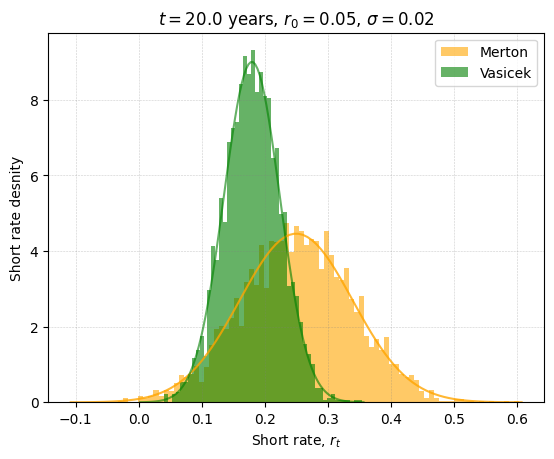

In [5]:
sigma_M = np.sqrt(variance_M)
x_M = np.linspace(mean_M - 4*sigma_M, mean_M + 4*sigma_M, 100)

sigma_V = np.sqrt(variance_V)
x_V = np.linspace(mean_V - 4*sigma_V, mean_V + 4*sigma_V, 100)

plt.figure()
plt.title(fr"$t =${t} years, $r_0=${r0}, $\sigma=${vol}")
plt.plot(x_M, stats.norm.pdf(x_M, mean_M, sigma_M), color='orange', alpha=0.8)
plt.hist(rates_M, bins=80, alpha=0.6, density=True, label="Merton", color='orange')
plt.plot(x_V, stats.norm.pdf(x_V, mean_V, sigma_V), color='green', alpha=0.6)
plt.hist(rates_V, bins=50, alpha=0.6, density=True, label="Vasicek", color='green')
plt.grid(color="grey", linewidth=0.4, linestyle="--", alpha=0.4)
plt.legend()
plt.xlabel(r"Short rate, $r_t$")
plt.ylabel(r"Short rate desnity")
plt.show()

In [6]:
simulation_times = np.linspace(0, 25, 200)

mean_M, mean_V = [], []
var_M, var_V = [], []

for s in simulation_times:
    mean, variance = merton.short_rate_moments(s)
    mean_M.append(mean)
    var_M.append(variance)

    mean, variance = vasicek.short_rate_moments(s)
    mean_V.append(mean)
    var_V.append(variance)

Both the Merton and Vasicek models produce normally distributed short rates, $r_t \sim \mathcal{N}(\text{mean}, \text{variance})$. The mean and variance of the Merton and Vasicek short rates $r_t$ can be computed analytically:

### Merton:
\begin{align}
\mathbb{E} [r_t] &= r_0 + \theta t \\
\mathbb{V}ar [r_t] &= \sigma^2 t
\end{align}

### Vasicek:
\begin{align}
\mathbb{E} [r_t] &= r_0 \exp(-kt) + \tilde{\theta} \, G(0, t \,|\, k) \\
\mathbb{V}ar [r_t] &= \sigma^2 G(0, t \,|\, 2k)
\end{align}

where $G(0, t \,|\, k)$ is given as:
\begin{align}
G(0,t \,|\, k) = \frac{1 - \exp(-kt)}{k}
\end{align}

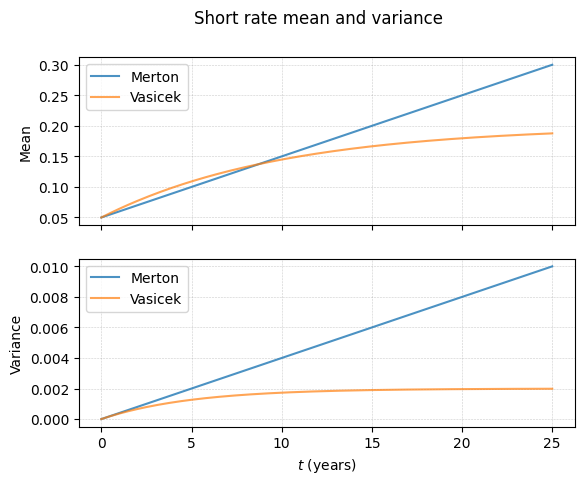

In [7]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Short rate mean and variance')
plt.xlabel(r'$T$ (years)')

ax1.plot(simulation_times, mean_M, label='Merton', alpha=0.8)
ax1.plot(simulation_times, mean_V, label='Vasicek', alpha=0.7)
ax1.set(ylabel=r'Mean')

ax2.plot(simulation_times, var_M, label='Merton', alpha=0.8)
ax2.plot(simulation_times, var_V, label='Vasicek', alpha=0.7)
ax2.set(xlabel=r'$t$ (years)', ylabel=r'Variance')

ax1.grid(color="grey", linewidth=0.4, linestyle="--", alpha=0.4)
ax2.grid(color="grey", linewidth=0.4, linestyle="--", alpha=0.4)
ax1.legend()
ax2.legend()

plt.show()

## Model Implied Rate Curves

Given the short rate $r_t$, we can compute the **model implied day-0 discount curve**, $T \mapsto B(0, T)$, where the ZCB price is given as:

\begin{align}
B(t, T) = \mathbb{E} \bigg[\exp \bigg( -\int_t^T r_u \, du \bigg) | \mathcal{F}_t \bigg] 
\end{align}

Once we have the model implied day-0 discount curve (aka zero curve), $T \mapsto B(0, T)$, we can also compute the **model implied day-0 yield curve**:
\begin{align}
T \mapsto R(0, T) \equiv -\frac{\ln B(0, T)}{T}
\end{align}

In [8]:
Ts = np.linspace(0.0001, 80, 200)

ZCBs_M = [merton.df(0,T,1) for T in Ts]
yeilds_M = [merton.bond_yield(0,T,1) for T in Ts]

ZCBs_V = [vasicek.df(0,T,1) for T in Ts]
yeilds_V = [vasicek.bond_yield(0,T,1) for T in Ts]

Let $X_T \equiv \int_0^T r_u \, du$ denote the log money market account, then the day-0 ZCB price is given as:
\begin{align}
B(0, T) &= \mathbb{E} \big[\exp \big( -X_T \big) \big] \\
        &= \exp \bigg( -\mathbb{E}[X_T] + \frac{1}{2} \mathbb{V}ar[X_T] \bigg)
\end{align}

This implies that the yield curve is given as:
\begin{align}
R(0, T) &= \frac{1}{T} \bigg( \mathbb{E}[X_T] - \frac{1}{2} \mathbb{V}ar[X_T] \bigg)
\end{align}

Again, the mean and variance of $X_T \equiv -\int_0^T r_u \, du$ can be computed analytically for the Merton and Vasicek model.

### Merton:
\begin{align}
\mathbb{E} [X_T] &= -r_0 T - \frac{1}{2} \theta T^2 \\
\mathbb{V}ar [X_T] &= \frac{1}{3} \sigma^2 T^3
\end{align}

### Vasicek:
\begin{align}
\mathbb{E} [X_T] &= r_0 \, G(0, T \,|\, k) + \tilde{\theta} \int_0^T G(u, T \,|\, k) \, du \\
\mathbb{V}ar [X_T] &= \sigma^2 \int_0^T G^2(u, T \,|\, k) \, du
\end{align}


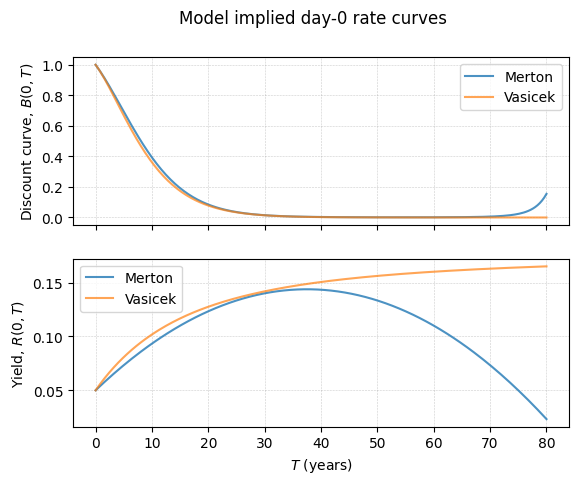

In [9]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Model implied day-0 rate curves')
plt.xlabel(r'$T$ (years)')

ax1.plot(Ts, ZCBs_M, label='Merton', alpha=0.8)
ax1.plot(Ts, ZCBs_V, label='Vasicek', alpha=0.7)
ax1.set(ylabel=r'Discount curve, $B(0,T)$')

ax2.plot(Ts, yeilds_M, label='Merton', alpha=0.8)
ax2.plot(Ts, yeilds_V, label='Vasicek', alpha=0.7)
ax2.set(xlabel=r'$T$ (years)', ylabel=r'Yield, $R(0,T)$')

ax1.grid(color="grey", linewidth=0.4, linestyle="--", alpha=0.4)
ax2.grid(color="grey", linewidth=0.4, linestyle="--", alpha=0.4)
ax1.legend()
ax2.legend()

plt.show()